In [12]:
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [13]:
index_null_del_user_place = pd.read_csv('../Data/whyout_data/index_null_del_user_place.csv', index_col=0).astype(dtype='float16')
index_null_del_user_product = pd.read_csv('../Data/whyout_data/index_null_del_user_product.csv', index_col=0).astype(dtype='float16')
index_null_del_user_video = pd.read_csv('../Data/whyout_data/index_null_del_user_video.csv', index_col=0).astype(dtype='float16')

In [14]:
sgd_place_df = pd.read_csv('../Data/whyout_data/sgd_result/place_k50epochs1000.csv', index_col=0).astype(dtype='float16')
sgd_product_df = pd.read_csv('../Data/whyout_data/sgd_result/product_k50epochs1000.csv', index_col=0).astype(dtype='float16')
sgd_video_df = pd.read_csv('../Data/whyout_data/sgd_result/video_k50epochs1000.csv', index_col=0).astype(dtype='float16')

In [ ]:
# 0이 아닌 값의 위치 찾기
non_zero_indices = np.argwhere(index_null_del_user_place.values == 0)

# 0이 아닌 값의 위치에 대응되는 sgd_place_df 값 추출
matching_values = []
for idx in non_zero_indices:
    row, col = idx
    matching_value = sgd_place_df.iloc[row, col]
    original_value = index_null_del_user_place.iloc[row, col]
    matching_values.append((row, col, original_value, matching_value))

# 매칭된 값 출력
for match in matching_values:
    if match[2] == 0:
        print(f"Index ({match[0]}, {match[1]}): Original Value = {match[2]}, SGD Place Value = {match[3]}")

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 0이 아닌 값의 위치 찾기
non_zero_indices = np.argwhere(index_null_del_user_place.values == 0)

# 0이 아닌 값의 위치에 대응되는 sgd_place_df 값 추출
original_values = []
sgd_values = []
for idx in non_zero_indices:
    row, col = idx
    original_value = index_null_del_user_place.iloc[row, col]
    sgd_value = sgd_place_df.iloc[row, col]
    original_values.append(original_value)
    sgd_values.append(sgd_value)

# numpy 배열로 변환
original_values = np.array(original_values)
sgd_values = np.array(sgd_values)

# 평균 절대 오차 (MAE)
mae = mean_absolute_error(original_values, sgd_values)

# 평균 제곱 오차 (MSE)
mse = mean_squared_error(original_values, sgd_values)

# 상관 계수 (Correlation Coefficient)
correlation = np.corrcoef(original_values, sgd_values)[0, 1]

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Correlation Coefficient: {correlation}")

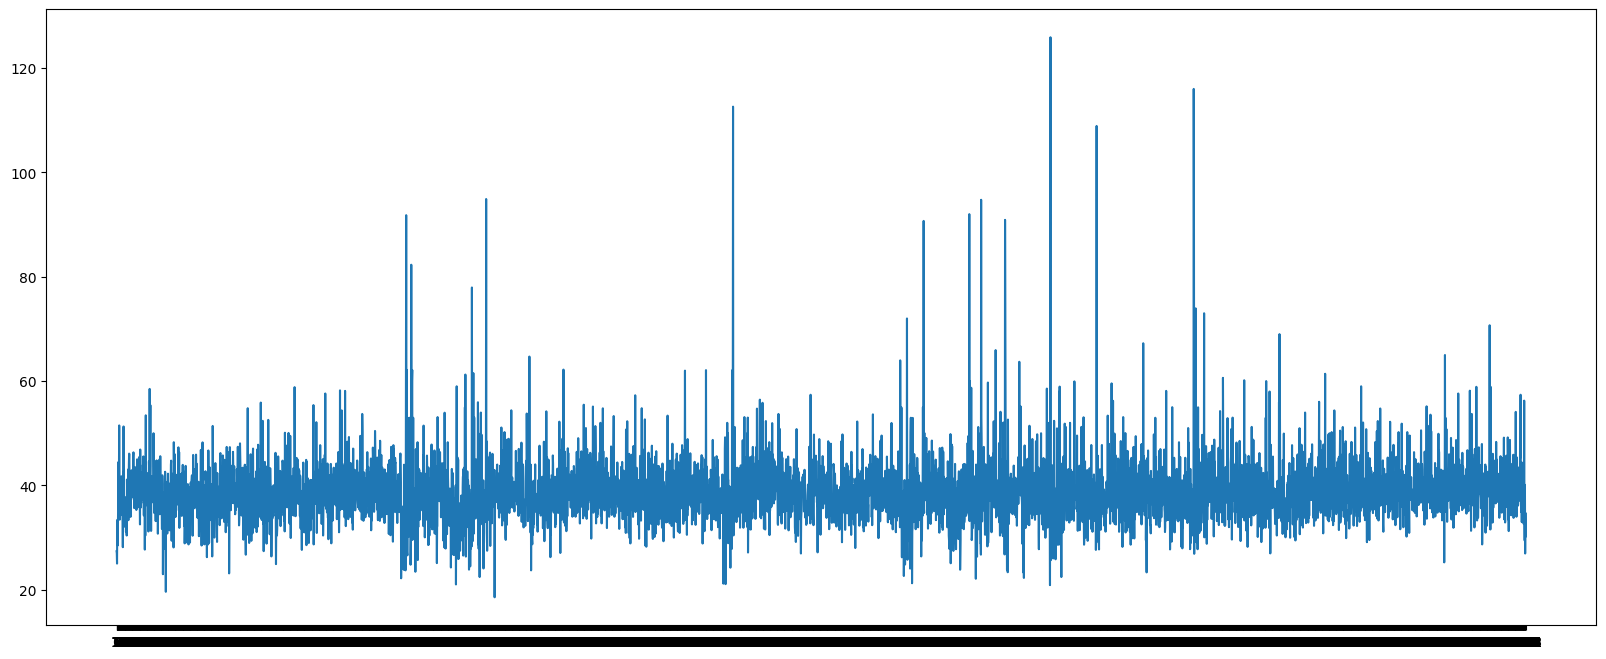

In [16]:
plt.figure(figsize=(20, 8))
plt.plot(sgd_product_df.max())